In [20]:
!git add C2_RNN_unstable_gradients.ipynb
!git commit -m "RNN unstable gradients checkin"
!git push

The file will have its original line endings in your working directory


[master de662be] RNN unstable gradients checkin
 1 file changed, 279 insertions(+), 8 deletions(-)


To https://github.com/auslei/python.git
   f5b12a8..de662be  master -> master


## Rcurent Neural Networks - Layer Normalisation

RNN suffers from unstable gradient problem. The common non-saturating activation functions may not work and lead to explosive gradient, as the neuron output is also related all previous inputs. Batch normalisation (apply normalisation after output to improve signal) will work only between RNN layers but not within timesteps, this does not improve result much. An alternative normalisation is called *layer normalisation*, which normalising across features rather than batch, which can be effective. Normally used right after the linear combination of inputs and hidden states.

In [9]:
## generate test data
import numpy as np
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 + np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) #wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

n_steps = 50
series = generate_time_series(10000, n_steps + 10) # returns numpy array of [batch_size, timestep, 1] - univariate dataset

## Create a custom RNN layer with Layer Normalisation

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, SimpleRNN, Dense, LSTM, GRU

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation = "tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation = None) # simple RNN cell, without activation
        self.layer_norm = keras.layers.LayerNormalization() # normalisation is done before activation
        self.activation = keras.activations.get(activation)
    
    # links everything together
    def call(self, inputs, states):  #current inputs and previous hidden states
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs] # the return value is output and new hidden states

ModuleNotFoundError: No module named 'tensorflow'

## Train RNN to forcast serveral timesteps ahead

### Series to Vector: Passing a series and returns of a vector

In [3]:
keras.backend.clear_session()

# get series to vector
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

model = Sequential([    
    RNN(LNSimpleRNNCell(20), return_sequences = True, input_shape = [None, 1]),
    RNN(LNSimpleRNNCell(20)),
    Dense(10)
])

es_cb = keras.callbacks.EarlyStopping(patience=5, min_delta = 1e3)

model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train, callbacks = es_cb, validation_data=(X_valid, y_valid), 
                     epochs = 30, verbose = False)
model.evaluate(X_test, y_test)

NameError: name 'keras' is not defined

### Series to Series

Instead of returning a vector of the next # of steps, instead we can return the next # steps for each of the timestep. This is called series to series.

In [4]:
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):   # each target is a 10D vector (for each step, get the next 10 steps)
    Y[:, :, step_ahead - 1] = series[:, step_ahead : step_ahead + n_steps, 0]  # for each of the 10 targets in y, shift x across 10 steps and take the next 10 value
    
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [5]:
keras.backend.clear_session()

model2 = Sequential([
    RNN(LNSimpleRNNCell(20), return_sequences = True, input_shape = [None, 1]),
    RNN(LNSimpleRNNCell(20), return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model2.summary()

# note as we are predicting next 10 values, only the last set of values are required to calc mse
def last_time_step_mse(Y_true, y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], y_pred[:, -1])

model2.compile(loss = last_time_step_mse, optimizer = 'adam')
history = model2.fit(X_train, Y_train, callbacks = es_cb, validation_data=(X_valid, Y_valid), 
                     epochs = 30, verbose = False)
model2.evaluate(X_test, Y_test)

NameError: name 'keras' is not defined

In [6]:
from matplotlib import pyplot as plt
Y_pred = model2.predict(X_test[:1])

plt.title("Predicted / and first/last predicted step of each timestep")
plt.plot(np.arange(50), X_test[:1].squeeze(), c = 'b', alpha = 0.2)
plt.plot(np.arange(60)[-10:], Y_test[:1, -1:, :].squeeze(), c = 'g')
plt.plot(np.arange(60)[-10:], Y_pred[:1, -1:, :].squeeze(), c = 'c', linestyle = '--')
for i in range(50):
    yp = Y_pred[:1, i, :1].squeeze()
    yp2 = Y_pred[:1, i, -1:].squeeze()
    plt.scatter(i, yp, s = 100, c = 'r', alpha = 0.2)
    plt.scatter(i + 10, yp2, s = 100, c = 'c', alpha = 0.2)

NameError: name 'model2' is not defined

## Short-term memory problem
Due to the transformation that goes into place when tranversing through RNN, some information will be lost at each step, after a while the information maybe totally lost. To tackle this problem various cells with long time memory has been introduced. 

## LSTM

**Long Short-Term Meomory(LSTM)** cell is provent to be performing very well and faster to converge. To use it, simply replace with LSTM.

- 3 inbound: 
    - a long term memory input $c_{(t-1)}$ 
    - a short term memory (previous state_ $h_{(t-1)}$
    - current time step input $x_{(t)}$
- 3 gates using logistic activation:
    - a forget gate $f_{(t)}$ and an element-wise multiplication with $c_{(t-1)}$
    - a input gate $i_{(t)}$ and an element-wise multiplication with $g_{(t)}$
    - a output gate $o_{(t)}$ and an element-wise multiplication with the sum of long and short out of the forget and input gates
- outputs:
    - long term memory $c_{(t)}$  
    - short term memory $h_{(t)}$
    - output $y_{(t)}$ which is equal to short term momory

see page 516, pretty clear

In [7]:
keras.backend.clear_session()

model3 = Sequential([
    LSTM(20, return_sequences = True, input_shape = [None, 1]),
    LSTM(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model3.summary()

# note as we are predicting next 10 values, only the last set of values are required to calc mse
def last_time_step_mse(Y_true, y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], y_pred[:, -1])

model3.compile(loss = last_time_step_mse, optimizer = 'adam')
history = model3.fit(X_train, Y_train, callbacks = es_cb, validation_data=(X_valid, Y_valid), 
                     epochs = 30, verbose = False)
model3.evaluate(X_test, Y_test)

NameError: name 'keras' is not defined

In [8]:
from matplotlib import pyplot as plt
Y_pred = model3.predict(X_test[:1])

plt.title("Predicted / and first/last predicted step of each timestep")
plt.plot(np.arange(50), X_test[:1].squeeze(), c = 'b', alpha = 0.2)
plt.plot(np.arange(60)[-10:], Y_test[:1, -1:, :].squeeze(), c = 'g')
plt.plot(np.arange(60)[-10:], Y_pred[:1, -1:, :].squeeze(), c = 'c', linestyle = '--')
for i in range(50):
    yp = Y_pred[:1, i, :1].squeeze()
    yp2 = Y_pred[:1, i, -1:].squeeze()
    plt.scatter(i, yp, s = 100, c = 'r', alpha = 0.2)
    plt.scatter(i + 10, yp2, s = 100, c = 'c', alpha = 0.2)

NameError: name 'model3' is not defined

## GRU Cells
**Gated Recurrent Unit** cell is a simplified version of LSTM, which seemed to perform just as well:

- Both state vectors are merged into one single $h_{(t)}$
- single gate controller $z_{(t)}$ now controls both forget and input gates (forget gate open (1) when input gate is closed (0)) 
- no output gate, where full state vector is output for every single time step

    $z_{(t)} = \sigma(W_{xz}^Tx_{(t)} + W_{hz}^Th_{(t-1)} + b_z)$   This gate controls what if we forget previous state or use the new state (erease old state when new is required)
    
    $r_{(t)} = \sigma(W_{xr}^Tx_{(t)} + W_{hr}^Th_{(t-1)} + b_r)$   This gate controls if which part of the previous state will be used
    
    $g_{(t)} = \tanh(W_{xg}^Tx_{(t)} + W_{hg}^T(r_{(t)}\otimes h_{(t-1)}) + b_g)$  This is the main layer which is a sume of the input with weight and some part of the previous state
    
    $h_{(t)} = z_{(t)} \otimes h_{(t-1)} + (1 - z_{(t)}) \otimes g_{(t)} $


Both LSTM and GRU are good but cannot tackle long sequences (>100 timesteps or more). 

In [29]:
keras.backend.clear_session()

model4 = Sequential([
    GRU(20, return_sequences = True, input_shape = [None, 1]),
    GRU(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model4.summary()

# note as we are predicting next 10 values, only the last set of values are required to calc mse
def last_time_step_mse(Y_true, y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], y_pred[:, -1])

model4.compile(loss = last_time_step_mse, optimizer = 'adam')
history = model4.fit(X_train, Y_train, callbacks = es_cb, validation_data=(X_valid, Y_valid), 
                     epochs = 30, verbose = False)
model4.evaluate(X_test, Y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________
32/32 [==============================] - 0s 4ms/step - loss: 0.0327


0.03273937851190567

## Using 1D convolutional layers to process Sequences

1D covolution layers can be used to shorten sequences. Sliding across data using 1D Convolution allowing each kernal to learn a short sequence, thus reduce the size of the overall sequence. (of course to reduce size, we will use either valid padding or stride greater than 1).

In [32]:
keras.backend.clear_session()

model5 = Sequential([
    keras.layers.Conv1D(filters = 20, kernel_size = 4, strides = 2, padding = "valid" , input_shape = [None, 1]),
    GRU(20, return_sequences = True),
    GRU(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model5.summary()

# note as we are predicting next 10 values, only the last set of values are required to calc mse
def last_time_step_mse(Y_true, y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], y_pred[:, -1])

model5.compile(loss = last_time_step_mse, optimizer = 'adam')
history = model5.fit(X_train, Y_train, callbacks = es_cb, validation_data=(X_valid, Y_valid), 
                     epochs = 30, verbose = False)
model5.evaluate(X_test, Y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          100       
_________________________________________________________________
gru (GRU)                    (None, None, 20)          2520      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________
32/32 [==============================] - 0s 2ms/step - loss: 0.0168


0.016818638890981674

## Wavenet

This is to stack CONV1D layers, doubling dilation rate at each layer. The dilation rate is a measure how far are each step apart, therefore the lower layers will learn short-term patterns and upper layers the long term. This allows us to train very large sequences very effectively.

In [38]:
keras.backend.clear_session()


model6 = Sequential()
model6.add(keras.layers.InputLayer(input_shape = X_train.shape[1:]))
for rate in (1, 2, 4, 8) * 2:
    model6.add(keras.layers.Conv1D(filters = 20, kernel_size = 2, padding = "causal", activation = "relu", dilation_rate = rate))
    
model6.add(keras.layers.Conv1D(filters = 10, kernel_size = 1)) 

model6.summary()

# note as we are predicting next 10 values, only the last set of values are required to calc mse
def last_time_step_mse(Y_true, y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], y_pred[:, -1])

model6.compile(loss = last_time_step_mse, optimizer = 'adam')
history = model6.fit(X_train, Y_train, callbacks = es_cb, validation_data=(X_valid, Y_valid), 
                     epochs = 30, verbose = False)
model6.evaluate(X_test, Y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 20)            60        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 20)            820       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 20)            820       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 20)            820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 50, 20)            820       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 50, 20)            820       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 50, 20)            8

0.023111969232559204

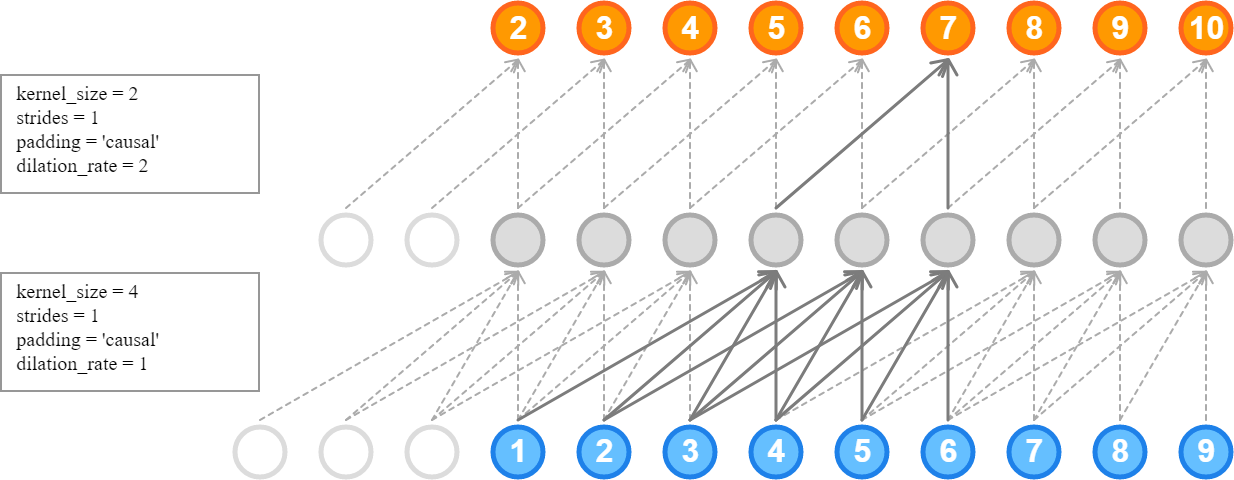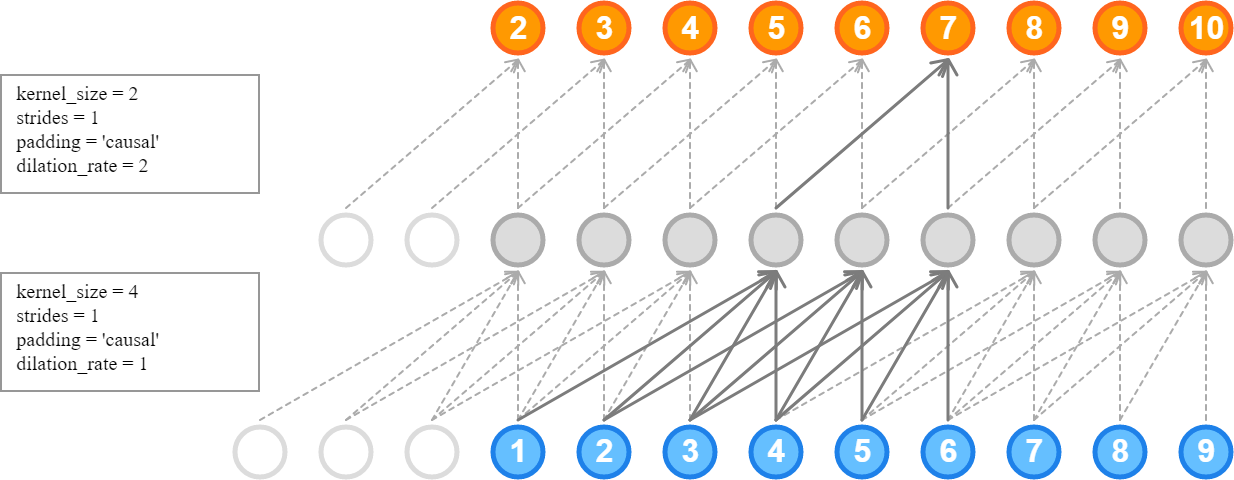

## Some RNN Shape intuitions

In [10]:
import numpy as np
import tensorflow as tf

inputs = np.random.random([32, 10, 8]).astype(np.float32)
simple_rnn = tf.keras.layers.SimpleRNN(4)

output = simple_rnn(inputs)  # The output has shape `[32, 4]`.

simple_rnn = tf.keras.layers.SimpleRNN(
    4, return_sequences=True, return_state=True)

# whole_sequence_output has shape `[32, 10, 4]`.
# final_state has shape `[32, 4]`.
whole_sequence_output, final_state = simple_rnn(inputs)

print(output.shape, whole_sequence_output.shape, final_state.shape)

(32, 4) (32, 10, 4) (32, 4)


In [19]:
import sys
sys.path.append("D:\graphviz-2.44.1-win32\Graphviz\bin")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

#deep model with mulitple layers
model = Sequential([
    SimpleRNN(1, return_sequences = False, input_shape = [50, 3]),    # 3 features and 1 per Wx and Wy
    Dense(1) # last do not neeed the return sequencies
])

model.summary()

model2 = Sequential([
    SimpleRNN(2, return_sequences = False, input_shape = [50, 3]),    
    Dense(1) # last do not neeed the return sequencies
])

model2.summary()


model3 = Sequential([
    SimpleRNN(3, return_sequences = False, input_shape = [50, 3]),   
    Dense(1) # last do not neeed the return sequencies
])

model3.summary()


model4 = Sequential([
    SimpleRNN(4, return_sequences = False, input_shape = [50, 3]),  
    Dense(1) # last do not neeed the return sequencies
])

model4.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_22 (SimpleRNN)    (None, 1)                 5         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 2         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_23 (SimpleRNN)    (None, 2)                 12        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_22"
_________________

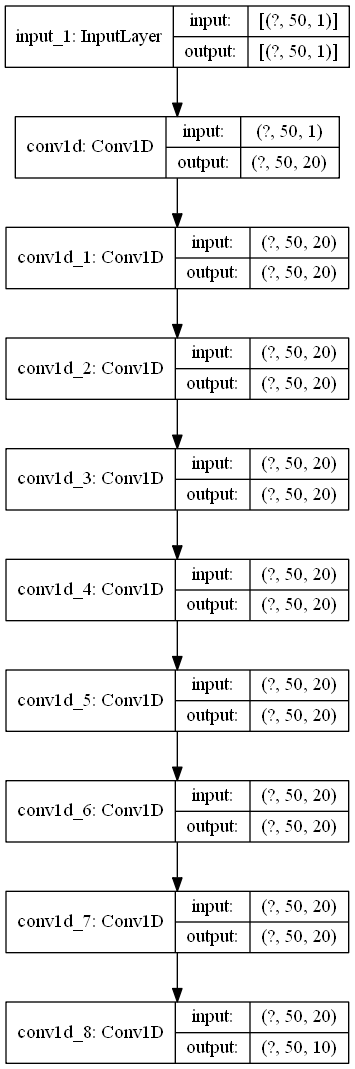

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(model6, show_shapes=True, show_layer_names=True)